
    Задание для лабораторной работы по автоэнкодерам (6)
1. Создайте сверточный шумоподавляющий автоэнкодер, который удаляет шум с изображений из набора данных CIFAR10.
2. Разработайте функцию, которая принимает на вход изображение с шумом из набора данных CIFAR10 и возвращает восстановленное изображение.

In [23]:

from keras.models import Sequential

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
import matplotlib.pyplot as plt


In [2]:
from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test  = np.reshape(x_test,  (len(x_test),  32, 32, 3))

In [4]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [42]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

NameError: name 'input_encoded' is not defined

In [6]:
history = model.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 529s 11ms/step - loss: 0.5926 - val_loss: 0.6013
Epoch 2/5
50000/50000 [==============================] - 539s 11ms/step - loss: 0.5777 - val_loss: 0.5771
Epoch 3/5
50000/50000 [==============================] - 531s 11ms/step - loss: 0.5738 - val_loss: 0.5757
Epoch 4/5
50000/50000 [==============================] - 537s 11ms/step - loss: 0.5716 - val_loss: 0.5717
Epoch 5/5
50000/50000 [==============================] - 525s 11ms/step - loss: 0.5700 - val_loss: 0.5701


In [8]:
c10test = model.predict(x_test)

In [60]:
import keras.backend as K
from keras.layers import Lambda

batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 32, 32, 3))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(model)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [62]:
denoiser_model.fit(x_train, x_train,
                   epochs=5,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 544s 11ms/step - loss: 0.5679 - val_loss: 0.5688
Epoch 2/5
50000/50000 [==============================] - 595s 12ms/step - loss: 0.5676 - val_loss: 0.5701
Epoch 3/5
50000/50000 [==============================] - 628s 13ms/step - loss: 0.5674 - val_loss: 0.5655
Epoch 4/5
50000/50000 [==============================] - 597s 12ms/step - loss: 0.5671 - val_loss: 0.5671
Epoch 5/5
50000/50000 [==============================] - 647s 13ms/step - loss: 0.5669 - val_loss: 0.5651


In [ ]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

In [35]:
def plot_images(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

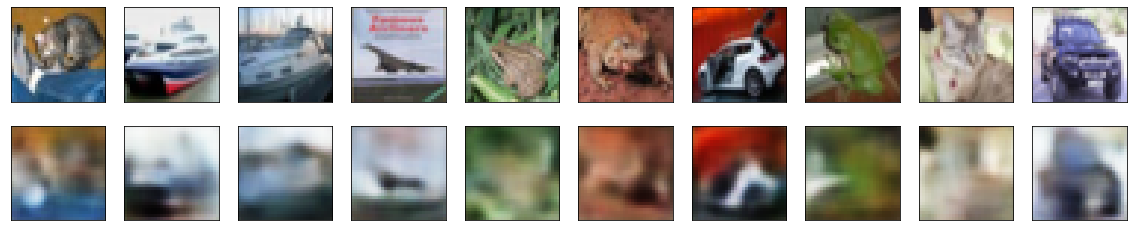

In [43]:
plot_images(x_test[:10], c10test[:10])

In [91]:

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

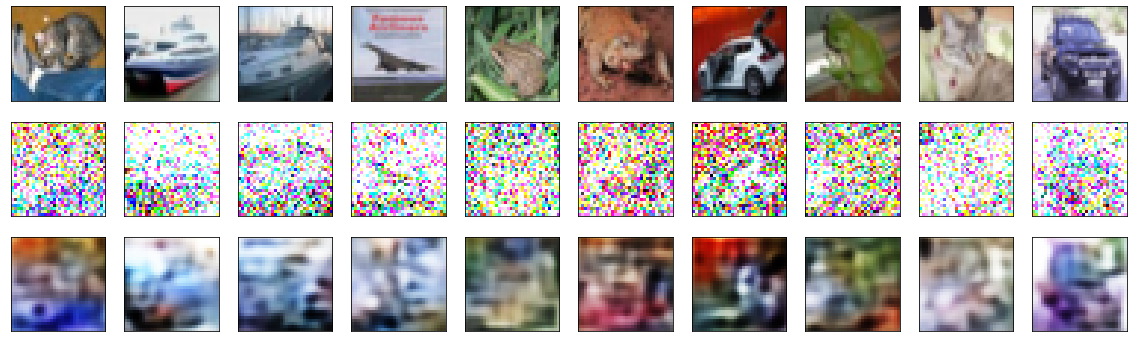

In [93]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
decoded_imgs = model.predict(noised_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

In [94]:
def clear_img(num):
    plt.figure(figsize=(2*1, 2*1))
    ax = plt.subplot(1, 1,  1)
    plt.imshow(decoded_imgs[num].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

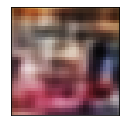

In [95]:
num=5
clear_img(num) 